# Whatami

I am a simple experiment on using VIME with actor-critic agent setup for MountainCar problem.

Original experiment: https://github.com/justheuristic/vime

Vime performance varies greatly depending on BNN.curiosity parameter so pls pay attention to it :)
* Large curiosity makes agent quickly learn to do weird things, some of which improve it's policy
* Low curiosity is close to vanilla a2c



## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


In [1]:
%load_ext autoreload
%autoreload 2

# Experiment setup
* Here we basically just load the game and check that it works

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS="floatX=float32"

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


env: THEANO_FLAGS="floatX=float32"


In [3]:
#global params.
GAME = "MountainCar-v0"

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
env = gym.make(GAME)
obs = env.step(0)[0]
action_names = np.array(["left",'stop',"right"]) #i guess so... i may be wrong
state_size = len(obs)
print(obs)

[2016-11-28 03:19:44,511] Making new env: MountainCar-v0


[-0.40586736 -0.00187794]


# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [7]:
import lasagne
from lasagne.layers import InputLayer,DenseLayer,NonlinearityLayer,batch_norm,dropout
#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,state_size))

dense0 = DenseLayer(observation_layer,100,name='dense1')
dense1 = DenseLayer(dense0,256,name='dense2')


Couldn't import dot_parser, loading of dot files will not be possible.


In [8]:
#a layer that predicts Qvalues

policy_layer = DenseLayer(dense1,
                   num_units = env.action_space.n,
                   nonlinearity=lasagne.nonlinearities.softmax,
                   name="q-evaluator layer")


V_layer = DenseLayer(dense1, 1, nonlinearity=None,name="state values")

In [9]:


import theano
epsilon = theano.shared(np.float32(0),allow_downcast=True)
policy_smooth_layer = NonlinearityLayer(policy_layer,
                                        lambda p: (1.-epsilon)*p + epsilon/env.action_space.n)

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_smooth_layer,
                                     name="e-greedy action picker",
                                     assume_normalized=True)



##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [10]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(policy_layer,V_layer),
              action_layers=action_layer)


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params((action_layer,V_layer),trainable=True)
weights

[dense1.W,
 dense1.b,
 dense2.W,
 dense2.b,
 q-evaluator layer.W,
 q-evaluator layer.b,
 state values.W,
 state values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,GAME, N_AGENTS,max_size=10000)


[2016-11-28 03:19:45,651] Making new env: MountainCar-v0


In [13]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log])
print(reward_log)

[['right' 'left' 'left' 'right' 'left' 'left' 'left']]
[[-1. -1. -1. -1. -1. -1.  0.]]
CPU times: user 4.85 ms, sys: 252 µs, total: 5.1 ms
Wall time: 4.4 ms


In [14]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# a2c loss

Here we define obective function for actor-critic (one-step) RL.

* We regularize policy with expected inverse action probabilities (discouraging very small probas) to make objective numerically stable


In [15]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(policy_seq,V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)



In [16]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import a2c_n_step

#loss for actor-critic

elwise_mse_loss = a2c_n_step.get_elementwise_objective(policy_seq,V_seq[:,:,0],
                                                       replay.actions[0],
                                                       replay.rewards,
                                                       replay.is_alive,
                                                       gamma_or_gammas=0.99,
                                                       n_steps=1)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [17]:
from theano import tensor as T
reg_entropy = T.mean((1./policy_seq))
loss += 0.01*reg_entropy

In [18]:
# Compute weight updates
updates = lasagne.updates.rmsprop(loss,weights,learning_rate=0.001)

In [19]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)


# Demo run

In [20]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=False)

[2016-11-28 03:19:55,894] Making new env: MountainCar-v0
[2016-11-28 03:19:55,897] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-11-28 03:19:55,940] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 200 timesteps with reward=-200.0


In [21]:
from IPython.display import HTML

video_path="<insert path from previous cell starting from records>"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Vime

In [22]:
from bnn import bbpwrap, NormalApproximation,sample_output
from lasagne.layers import EmbeddingLayer
import theano.tensor as T
@bbpwrap(NormalApproximation())
class BayesDenseLayer(DenseLayer):pass
@bbpwrap(NormalApproximation())
class BayesEmbLayer(EmbeddingLayer):pass

from curiosity import compile_vime_reward

class BNN:
    curiosity=0.01
    target_rho = 1
    
    l_state = InputLayer((None,state_size),name='state var')
    l_action = InputLayer((None,),input_var=T.ivector())

    l_action_emb = BayesEmbLayer(l_action,env.action_space.n, 3)    
    
    l_concat = lasagne.layers.concat([l_action_emb,l_state])
    
    l_dense = BayesDenseLayer(l_concat,num_units=50,
                              nonlinearity=lasagne.nonlinearities.tanh)
    
    l_out = BayesDenseLayer(l_dense,num_units=state_size,
                            nonlinearity=None)
        
    params = lasagne.layers.get_all_params(l_out,trainable=True)
    ###training###
    pred_states = lasagne.layers.get_output(l_out)
    next_states = T.matrix("next states")
    mse = lasagne.objectives.squared_error(pred_states,next_states).mean()
    
    #replace logposterior with simple regularization on rho cuz we're lazy
    reg = sum([lasagne.objectives.squared_error(rho,target_rho).mean() 
              for rho in lasagne.layers.get_all_params(l_out,rho=True)])
    
    loss = mse+ 0.01*reg
    
    updates = lasagne.updates.adam(loss,params)
    
    train_step = theano.function([l_state.input_var,l_action.input_var,next_states],
                                 loss,updates=updates)
    
    ###sample random sessions from pool###
    observations, = replay.observations
    actions, = replay.actions
    observations_flat = observations[:,:-1].reshape((-1,)+tuple(observations.shape[2:]))
    actions_flat = actions[:,:-1].reshape((-1,))
    next_observations_flat = observations[:,1:].reshape((-1,)+tuple(observations.shape[2:]))
    sample_from_pool = theano.function([],[observations_flat,actions_flat,next_observations_flat])

    
    ###curiosity reward### aka KL(qnew,qold)
    get_vime_reward_elwise = compile_vime_reward(l_out,l_state,l_action,params,n_samples=10)
    
    ###moving average of KL used to normalize over it
    vime_reward_ma = 10.
    ma_alpha=0.01

    @staticmethod
    def add_vime_reward(observations,actions,rewards,is_alive,h0):
        assert isinstance(observations,np.ndarray)
        observations_flat = observations[:,:-1].reshape((-1,)+observations.shape[2:]).astype('float32')
        actions_flat = actions[:,:-1].reshape((-1,)).astype('int32')
        next_observations_flat = observations[:,1:].reshape((-1,)+observations.shape[2:]).astype('float32')

        vime_rewards = BNN.get_vime_reward_elwise(observations_flat,actions_flat,next_observations_flat)
        vime_rewards = np.concatenate([vime_rewards.reshape(rewards[:,:-1].shape),
                                       np.zeros_like(rewards[:,-1:]),], axis=1)
        #normalize by moving average
        BNN.vime_reward_ma = (1.-BNN.ma_alpha)*BNN.vime_reward_ma + BNN.ma_alpha*vime_rewards.mean()
        
        surrogate_rewards = rewards + BNN.curiosity/BNN.vime_reward_ma*vime_rewards
        return (observations,actions,surrogate_rewards,is_alive,h0)
    
        


# Training loop

In [23]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [24]:
#pre-fill pool
from tqdm import tqdm
for i in tqdm(range(1000)):
    pool.update(SEQ_LENGTH,append=True,preprocess=BNN.add_vime_reward)

#pre-train BNN (mitigate training lag on first iterations where BNN is stupid)
for i in tqdm(range(1000)):
    BNN.train_step(*BNN.sample_from_pool())


100%|██████████| 1000/1000 [00:02<00:00, 372.28it/s]


In [25]:

#the loop may take eons to finish.
#consider interrupting early.
loss = 0
for i in tqdm(range(10000)):    
    
    
    #train
    for i in range(10):
        pool.update(SEQ_LENGTH,append=True,preprocess=BNN.add_vime_reward)

    for i in range(10):
        loss = loss*0.99 + train_step()*0.01
    
    for i in range(10):
        BNN.train_step(*BNN.sample_from_pool())

    
    if epoch_counter%100==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=1+pool.experience_replay.is_alive.get_value()[:,:-1])
        pool_size = pool.experience_replay.rewards.get_value().shape[0]
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f\tpool_size=%i\tvime ma=%.5f"%(epoch_counter,
                                                         epsilon.get_value(),
                                                         pool_mean_reward,
                                                         pool_size,
                                                         BNN.vime_reward_ma))
        

    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        n_games = 10
        epsilon.set_value(0)
        rewards[epoch_counter] = pool.evaluate( record_video=False,n_games=n_games,verbose=False)
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
        epsilon.set_value(0.05)
    
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 100/10000 [00:19<32:50,  5.02it/s]

iter=100	epsilon=0.000	reward/step=-0.98942	pool_size=2001	vime ma=3.89503


  2%|▏         | 201/10000 [00:39<30:03,  5.43it/s]

iter=200	epsilon=0.000	reward/step=-0.98942	pool_size=3001	vime ma=2.31922


  3%|▎         | 301/10000 [00:58<33:24,  4.84it/s]

iter=300	epsilon=0.000	reward/step=-0.98939	pool_size=4001	vime ma=1.57553


  4%|▍         | 401/10000 [01:17<30:18,  5.28it/s]

iter=400	epsilon=0.000	reward/step=-0.98938	pool_size=5001	vime ma=0.94941


  5%|▍         | 499/10000 [01:36<32:33,  4.86it/s][2016-11-28 03:21:48,990] Making new env: MountainCar-v0
[2016-11-28 03:21:48,994] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.000	reward/step=-0.98933	pool_size=6001	vime ma=0.64745


[2016-11-28 03:21:49,421] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
  5%|▌         | 500/10000 [01:36<55:58,  2.83it/s]

Current score(mean over 10) = -200.000


  6%|▌         | 600/10000 [01:57<33:23,  4.69it/s]

iter=600	epsilon=0.050	reward/step=-0.98927	pool_size=7001	vime ma=0.43053


  7%|▋         | 701/10000 [02:18<34:11,  4.53it/s]

iter=700	epsilon=0.050	reward/step=-0.98911	pool_size=8001	vime ma=0.30550


  8%|▊         | 801/10000 [02:38<28:17,  5.42it/s]

iter=800	epsilon=0.050	reward/step=-0.98883	pool_size=9001	vime ma=0.24422


  9%|▉         | 901/10000 [02:59<29:34,  5.13it/s]

iter=900	epsilon=0.050	reward/step=-0.98862	pool_size=10000	vime ma=0.15951


 10%|▉         | 999/10000 [03:19<27:36,  5.43it/s][2016-11-28 03:23:31,959] Making new env: MountainCar-v0
[2016-11-28 03:23:31,961] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.050	reward/step=-0.98831	pool_size=10000	vime ma=0.11891


[2016-11-28 03:23:32,285] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 10%|█         | 1001/10000 [03:19<37:50,  3.96it/s]

Current score(mean over 10) = -161.200


 11%|█         | 1101/10000 [03:39<26:54,  5.51it/s]

iter=1100	epsilon=0.050	reward/step=-0.98799	pool_size=10000	vime ma=0.08223


 12%|█▏        | 1201/10000 [03:56<26:26,  5.55it/s]

iter=1200	epsilon=0.050	reward/step=-0.98764	pool_size=10000	vime ma=0.05873


 13%|█▎        | 1301/10000 [04:15<28:00,  5.18it/s]

iter=1300	epsilon=0.050	reward/step=-0.98730	pool_size=10000	vime ma=0.04550


 14%|█▍        | 1401/10000 [04:33<26:01,  5.51it/s]

iter=1400	epsilon=0.050	reward/step=-0.98696	pool_size=10000	vime ma=0.03317


 15%|█▍        | 1499/10000 [04:51<25:58,  5.46it/s][2016-11-28 03:25:04,061] Making new env: MountainCar-v0
[2016-11-28 03:25:04,064] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.050	reward/step=-0.98664	pool_size=10000	vime ma=0.02510


[2016-11-28 03:25:04,373] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 15%|█▌        | 1501/10000 [04:52<35:01,  4.04it/s]

Current score(mean over 10) = -155.100


 16%|█▌        | 1601/10000 [05:10<25:24,  5.51it/s]

iter=1600	epsilon=0.050	reward/step=-0.98635	pool_size=10000	vime ma=0.01965


 17%|█▋        | 1701/10000 [05:28<24:52,  5.56it/s]

iter=1700	epsilon=0.050	reward/step=-0.98614	pool_size=10000	vime ma=0.01633


 18%|█▊        | 1801/10000 [05:46<24:34,  5.56it/s]

iter=1800	epsilon=0.050	reward/step=-0.98607	pool_size=10000	vime ma=0.01429


 19%|█▉        | 1901/10000 [06:04<24:05,  5.60it/s]

iter=1900	epsilon=0.050	reward/step=-0.98602	pool_size=10000	vime ma=0.01104


 20%|█▉        | 1999/10000 [06:22<24:07,  5.53it/s][2016-11-28 03:26:34,906] Making new env: MountainCar-v0
[2016-11-28 03:26:34,909] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=-0.98599	pool_size=10000	vime ma=0.01110


[2016-11-28 03:26:35,249] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 20%|██        | 2001/10000 [06:22<33:40,  3.96it/s]

Current score(mean over 10) = -165.800


 21%|██        | 2101/10000 [06:41<24:01,  5.48it/s]

iter=2100	epsilon=0.050	reward/step=-0.98595	pool_size=10000	vime ma=0.01088


 22%|██▏       | 2201/10000 [06:59<24:19,  5.34it/s]

iter=2200	epsilon=0.050	reward/step=-0.98593	pool_size=10000	vime ma=0.01056


 23%|██▎       | 2301/10000 [07:18<23:56,  5.36it/s]

iter=2300	epsilon=0.050	reward/step=-0.98591	pool_size=10000	vime ma=0.01012


 24%|██▍       | 2401/10000 [07:36<22:50,  5.55it/s]

iter=2400	epsilon=0.050	reward/step=-0.98588	pool_size=10000	vime ma=0.01065


 25%|██▍       | 2499/10000 [07:54<22:51,  5.47it/s][2016-11-28 03:28:07,001] Making new env: MountainCar-v0
[2016-11-28 03:28:07,004] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2500	epsilon=0.050	reward/step=-0.98584	pool_size=10000	vime ma=0.01196


[2016-11-28 03:28:07,298] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 25%|██▌       | 2501/10000 [07:55<30:34,  4.09it/s]

Current score(mean over 10) = -140.400


 26%|██▌       | 2601/10000 [08:13<22:22,  5.51it/s]

iter=2600	epsilon=0.050	reward/step=-0.98579	pool_size=10000	vime ma=0.01281


 27%|██▋       | 2701/10000 [08:31<22:25,  5.42it/s]

iter=2700	epsilon=0.050	reward/step=-0.98577	pool_size=10000	vime ma=0.01276


 28%|██▊       | 2801/10000 [08:49<21:34,  5.56it/s]

iter=2800	epsilon=0.050	reward/step=-0.98572	pool_size=10000	vime ma=0.01384


 29%|██▉       | 2901/10000 [09:08<21:29,  5.50it/s]

iter=2900	epsilon=0.050	reward/step=-0.98566	pool_size=10000	vime ma=0.01516


 30%|██▉       | 2999/10000 [09:26<21:05,  5.53it/s][2016-11-28 03:29:38,655] Making new env: MountainCar-v0
[2016-11-28 03:29:38,658] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3000	epsilon=0.050	reward/step=-0.98561	pool_size=10000	vime ma=0.01735


[2016-11-28 03:29:38,916] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 30%|███       | 3001/10000 [09:26<27:35,  4.23it/s]

Current score(mean over 10) = -135.200


 31%|███       | 3101/10000 [09:44<20:42,  5.55it/s]

iter=3100	epsilon=0.050	reward/step=-0.98556	pool_size=10000	vime ma=0.01806


 32%|███▏      | 3201/10000 [10:03<21:06,  5.37it/s]

iter=3200	epsilon=0.050	reward/step=-0.98553	pool_size=10000	vime ma=0.01898


 33%|███▎      | 3301/10000 [10:22<20:40,  5.40it/s]

iter=3300	epsilon=0.050	reward/step=-0.98552	pool_size=10000	vime ma=0.01951


 34%|███▍      | 3401/10000 [10:40<20:02,  5.49it/s]

iter=3400	epsilon=0.050	reward/step=-0.98550	pool_size=10000	vime ma=0.02220


 35%|███▍      | 3499/10000 [10:58<20:00,  5.42it/s][2016-11-28 03:31:10,856] Making new env: MountainCar-v0
[2016-11-28 03:31:10,859] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3500	epsilon=0.050	reward/step=-0.98548	pool_size=10000	vime ma=0.02412


[2016-11-28 03:31:11,096] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 35%|███▌      | 3501/10000 [10:58<25:25,  4.26it/s]

Current score(mean over 10) = -117.200


 36%|███▌      | 3601/10000 [11:17<19:24,  5.50it/s]

iter=3600	epsilon=0.050	reward/step=-0.98548	pool_size=10000	vime ma=0.02527


 37%|███▋      | 3701/10000 [11:35<19:30,  5.38it/s]

iter=3700	epsilon=0.050	reward/step=-0.98545	pool_size=10000	vime ma=0.02624


 38%|███▊      | 3801/10000 [11:53<19:49,  5.21it/s]

iter=3800	epsilon=0.050	reward/step=-0.98547	pool_size=10000	vime ma=0.02705


 39%|███▉      | 3901/10000 [12:12<19:40,  5.17it/s]

iter=3900	epsilon=0.050	reward/step=-0.98545	pool_size=10000	vime ma=0.02814


 40%|███▉      | 3999/10000 [12:31<18:34,  5.38it/s][2016-11-28 03:32:43,931] Making new env: MountainCar-v0
[2016-11-28 03:32:43,934] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4000	epsilon=0.050	reward/step=-0.98544	pool_size=10000	vime ma=0.03055


[2016-11-28 03:32:44,166] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 40%|████      | 4001/10000 [12:31<23:30,  4.25it/s]

Current score(mean over 10) = -116.600


 41%|████      | 4101/10000 [12:50<18:31,  5.31it/s]

iter=4100	epsilon=0.050	reward/step=-0.98542	pool_size=10000	vime ma=0.03256


 42%|████▏     | 4201/10000 [13:09<18:12,  5.31it/s]

iter=4200	epsilon=0.050	reward/step=-0.98539	pool_size=10000	vime ma=0.03505


 43%|████▎     | 4301/10000 [13:28<17:43,  5.36it/s]

iter=4300	epsilon=0.050	reward/step=-0.98537	pool_size=10000	vime ma=0.03684


 44%|████▍     | 4401/10000 [13:46<17:15,  5.41it/s]

iter=4400	epsilon=0.050	reward/step=-0.98536	pool_size=10000	vime ma=0.03807


 45%|████▍     | 4499/10000 [14:05<16:48,  5.45it/s][2016-11-28 03:34:17,768] Making new env: MountainCar-v0
[2016-11-28 03:34:17,770] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4500	epsilon=0.050	reward/step=-0.98535	pool_size=10000	vime ma=0.04080


[2016-11-28 03:34:18,022] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 45%|████▌     | 4501/10000 [14:05<21:59,  4.17it/s]

Current score(mean over 10) = -125.800


 46%|████▌     | 4601/10000 [14:24<16:30,  5.45it/s]

iter=4600	epsilon=0.050	reward/step=-0.98532	pool_size=10000	vime ma=0.04150


 47%|████▋     | 4701/10000 [14:42<16:31,  5.34it/s]

iter=4700	epsilon=0.050	reward/step=-0.98529	pool_size=10000	vime ma=0.04679


 48%|████▊     | 4801/10000 [15:01<16:00,  5.42it/s]

iter=4800	epsilon=0.050	reward/step=-0.98528	pool_size=10000	vime ma=0.04622


 49%|████▉     | 4901/10000 [15:19<16:28,  5.16it/s]

iter=4900	epsilon=0.050	reward/step=-0.98527	pool_size=10000	vime ma=0.04942


 50%|████▉     | 4999/10000 [15:37<15:16,  5.46it/s][2016-11-28 03:35:50,518] Making new env: MountainCar-v0
[2016-11-28 03:35:50,521] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5000	epsilon=0.050	reward/step=-0.98527	pool_size=10000	vime ma=0.04996


[2016-11-28 03:35:50,768] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 50%|█████     | 5001/10000 [15:38<19:29,  4.28it/s]

Current score(mean over 10) = -124.000


 51%|█████     | 5101/10000 [15:57<15:06,  5.40it/s]

iter=5100	epsilon=0.050	reward/step=-0.98528	pool_size=10000	vime ma=0.05426


 52%|█████▏    | 5201/10000 [16:15<14:29,  5.52it/s]

iter=5200	epsilon=0.050	reward/step=-0.98528	pool_size=10000	vime ma=0.05492


 53%|█████▎    | 5301/10000 [16:33<14:29,  5.40it/s]

iter=5300	epsilon=0.050	reward/step=-0.98529	pool_size=10000	vime ma=0.05637


 54%|█████▍    | 5401/10000 [16:52<14:06,  5.43it/s]

iter=5400	epsilon=0.050	reward/step=-0.98529	pool_size=10000	vime ma=0.05847


 55%|█████▍    | 5499/10000 [17:10<14:04,  5.33it/s][2016-11-28 03:37:23,393] Making new env: MountainCar-v0
[2016-11-28 03:37:23,396] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5500	epsilon=0.050	reward/step=-0.98531	pool_size=10000	vime ma=0.06046


[2016-11-28 03:37:23,676] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 55%|█████▌    | 5501/10000 [17:11<18:26,  4.07it/s]

Current score(mean over 10) = -123.500


 56%|█████▌    | 5601/10000 [17:29<13:36,  5.39it/s]

iter=5600	epsilon=0.050	reward/step=-0.98531	pool_size=10000	vime ma=0.06349


 57%|█████▋    | 5701/10000 [17:48<13:32,  5.29it/s]

iter=5700	epsilon=0.050	reward/step=-0.98534	pool_size=10000	vime ma=0.06411


 58%|█████▊    | 5801/10000 [18:07<12:52,  5.44it/s]

iter=5800	epsilon=0.050	reward/step=-0.98534	pool_size=10000	vime ma=0.06168


 59%|█████▉    | 5901/10000 [18:25<12:30,  5.47it/s]

iter=5900	epsilon=0.050	reward/step=-0.98534	pool_size=10000	vime ma=0.06867


 60%|█████▉    | 5999/10000 [18:43<12:23,  5.38it/s][2016-11-28 03:38:56,566] Making new env: MountainCar-v0
[2016-11-28 03:38:56,569] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6000	epsilon=0.050	reward/step=-0.98533	pool_size=10000	vime ma=0.06793


[2016-11-28 03:38:56,797] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 60%|██████    | 6001/10000 [18:44<15:31,  4.29it/s]

Current score(mean over 10) = -115.300


 61%|██████    | 6101/10000 [19:03<12:00,  5.41it/s]

iter=6100	epsilon=0.050	reward/step=-0.98533	pool_size=10000	vime ma=0.06868


 62%|██████▏   | 6200/10000 [19:21<11:58,  5.29it/s]

iter=6200	epsilon=0.050	reward/step=-0.98534	pool_size=10000	vime ma=0.07324


 63%|██████▎   | 6301/10000 [19:40<11:13,  5.49it/s]

iter=6300	epsilon=0.050	reward/step=-0.98532	pool_size=10000	vime ma=0.07646


 64%|██████▍   | 6401/10000 [19:59<11:06,  5.40it/s]

iter=6400	epsilon=0.050	reward/step=-0.98531	pool_size=10000	vime ma=0.07537


 65%|██████▍   | 6499/10000 [20:17<10:55,  5.34it/s][2016-11-28 03:40:30,246] Making new env: MountainCar-v0
[2016-11-28 03:40:30,250] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6500	epsilon=0.050	reward/step=-0.98531	pool_size=10000	vime ma=0.07968


[2016-11-28 03:40:30,483] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 65%|██████▌   | 6501/10000 [20:18<13:40,  4.27it/s]

Current score(mean over 10) = -118.500


 66%|██████▌   | 6601/10000 [20:36<10:34,  5.36it/s]

iter=6600	epsilon=0.050	reward/step=-0.98532	pool_size=10000	vime ma=0.07800


 67%|██████▋   | 6701/10000 [20:55<10:19,  5.32it/s]

iter=6700	epsilon=0.050	reward/step=-0.98531	pool_size=10000	vime ma=0.08015


 68%|██████▊   | 6801/10000 [21:14<09:53,  5.39it/s]

iter=6800	epsilon=0.050	reward/step=-0.98531	pool_size=10000	vime ma=0.08592


 69%|██████▉   | 6901/10000 [21:33<09:41,  5.33it/s]

iter=6900	epsilon=0.050	reward/step=-0.98533	pool_size=10000	vime ma=0.08751


 70%|██████▉   | 6999/10000 [21:52<09:21,  5.34it/s][2016-11-28 03:42:05,032] Making new env: MountainCar-v0
[2016-11-28 03:42:05,035] Clearing 2 monitor files from previous run (because force=True was provided)


iter=7000	epsilon=0.050	reward/step=-0.98535	pool_size=10000	vime ma=0.08666


[2016-11-28 03:42:05,264] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 70%|███████   | 7001/10000 [21:52<11:45,  4.25it/s]

Current score(mean over 10) = -115.400


 71%|███████   | 7100/10000 [22:11<08:54,  5.42it/s]

iter=7100	epsilon=0.050	reward/step=-0.98536	pool_size=10000	vime ma=0.08960


 72%|███████▏  | 7201/10000 [22:30<08:32,  5.46it/s]

iter=7200	epsilon=0.050	reward/step=-0.98534	pool_size=10000	vime ma=0.09546


 73%|███████▎  | 7301/10000 [22:48<08:11,  5.49it/s]

iter=7300	epsilon=0.050	reward/step=-0.98537	pool_size=10000	vime ma=0.09207


 74%|███████▍  | 7401/10000 [23:07<08:10,  5.29it/s]

iter=7400	epsilon=0.050	reward/step=-0.98537	pool_size=10000	vime ma=0.09166


 75%|███████▍  | 7499/10000 [23:25<07:46,  5.36it/s][2016-11-28 03:43:38,599] Making new env: MountainCar-v0
[2016-11-28 03:43:38,603] Clearing 2 monitor files from previous run (because force=True was provided)


iter=7500	epsilon=0.050	reward/step=-0.98536	pool_size=10000	vime ma=0.09724


[2016-11-28 03:43:38,838] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 75%|███████▌  | 7501/10000 [23:26<09:45,  4.27it/s]

Current score(mean over 10) = -122.500


 76%|███████▌  | 7601/10000 [23:45<07:28,  5.35it/s]

iter=7600	epsilon=0.050	reward/step=-0.98536	pool_size=10000	vime ma=0.09940


 77%|███████▋  | 7701/10000 [24:03<07:07,  5.37it/s]

iter=7700	epsilon=0.050	reward/step=-0.98535	pool_size=10000	vime ma=0.10291


 78%|███████▊  | 7800/10000 [24:22<07:06,  5.15it/s]

iter=7800	epsilon=0.050	reward/step=-0.98534	pool_size=10000	vime ma=0.10330


 79%|███████▉  | 7901/10000 [24:41<06:25,  5.45it/s]

iter=7900	epsilon=0.050	reward/step=-0.98535	pool_size=10000	vime ma=0.10223


 80%|███████▉  | 7999/10000 [24:59<06:15,  5.33it/s][2016-11-28 03:45:12,042] Making new env: MountainCar-v0
[2016-11-28 03:45:12,045] Clearing 2 monitor files from previous run (because force=True was provided)


iter=8000	epsilon=0.050	reward/step=-0.98533	pool_size=10000	vime ma=0.10439


[2016-11-28 03:45:12,303] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 80%|████████  | 8001/10000 [25:00<08:06,  4.11it/s]

Current score(mean over 10) = -128.400


 81%|████████  | 8101/10000 [25:18<05:50,  5.42it/s]

iter=8100	epsilon=0.050	reward/step=-0.98531	pool_size=10000	vime ma=0.10884


 82%|████████▏ | 8201/10000 [25:37<05:34,  5.37it/s]

iter=8200	epsilon=0.050	reward/step=-0.98532	pool_size=10000	vime ma=0.10987


 83%|████████▎ | 8301/10000 [25:56<05:24,  5.24it/s]

iter=8300	epsilon=0.050	reward/step=-0.98532	pool_size=10000	vime ma=0.10977


 84%|████████▍ | 8401/10000 [26:14<04:53,  5.44it/s]

iter=8400	epsilon=0.050	reward/step=-0.98534	pool_size=10000	vime ma=0.10989


 85%|████████▍ | 8499/10000 [26:33<04:47,  5.23it/s][2016-11-28 03:46:45,975] Making new env: MountainCar-v0
[2016-11-28 03:46:45,978] Clearing 2 monitor files from previous run (because force=True was provided)


iter=8500	epsilon=0.050	reward/step=-0.98534	pool_size=10000	vime ma=0.11233


[2016-11-28 03:46:46,248] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 85%|████████▌ | 8501/10000 [26:33<06:07,  4.07it/s]

Current score(mean over 10) = -131.000


 86%|████████▌ | 8601/10000 [26:52<04:19,  5.39it/s]

iter=8600	epsilon=0.050	reward/step=-0.98534	pool_size=10000	vime ma=0.11252


 87%|████████▋ | 8701/10000 [27:11<04:05,  5.30it/s]

iter=8700	epsilon=0.050	reward/step=-0.98535	pool_size=10000	vime ma=0.11566


 88%|████████▊ | 8801/10000 [27:30<03:41,  5.41it/s]

iter=8800	epsilon=0.050	reward/step=-0.98534	pool_size=10000	vime ma=0.12122


 89%|████████▉ | 8901/10000 [27:49<03:28,  5.27it/s]

iter=8900	epsilon=0.050	reward/step=-0.98535	pool_size=10000	vime ma=0.12177


 90%|████████▉ | 8999/10000 [28:07<03:06,  5.38it/s][2016-11-28 03:48:20,072] Making new env: MountainCar-v0
[2016-11-28 03:48:20,075] Clearing 2 monitor files from previous run (because force=True was provided)


iter=9000	epsilon=0.050	reward/step=-0.98535	pool_size=10000	vime ma=0.11984


[2016-11-28 03:48:20,310] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 90%|█████████ | 9001/10000 [28:08<03:56,  4.22it/s]

Current score(mean over 10) = -117.400


 91%|█████████ | 9101/10000 [28:26<02:45,  5.45it/s]

iter=9100	epsilon=0.050	reward/step=-0.98535	pool_size=10000	vime ma=0.12307


 92%|█████████▏| 9201/10000 [28:45<02:27,  5.41it/s]

iter=9200	epsilon=0.050	reward/step=-0.98537	pool_size=10000	vime ma=0.11798


 93%|█████████▎| 9301/10000 [29:03<02:09,  5.39it/s]

iter=9300	epsilon=0.050	reward/step=-0.98536	pool_size=10000	vime ma=0.12063


 94%|█████████▍| 9401/10000 [29:22<01:53,  5.26it/s]

iter=9400	epsilon=0.050	reward/step=-0.98535	pool_size=10000	vime ma=0.12402


 95%|█████████▍| 9499/10000 [29:41<01:32,  5.39it/s][2016-11-28 03:49:53,743] Making new env: MountainCar-v0
[2016-11-28 03:49:53,746] Clearing 2 monitor files from previous run (because force=True was provided)


iter=9500	epsilon=0.050	reward/step=-0.98536	pool_size=10000	vime ma=0.12238


[2016-11-28 03:49:53,973] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 95%|█████████▌| 9501/10000 [29:41<01:57,  4.26it/s]

Current score(mean over 10) = -119.100


 96%|█████████▌| 9601/10000 [30:00<01:24,  4.74it/s]

iter=9600	epsilon=0.050	reward/step=-0.98536	pool_size=10000	vime ma=0.12275


 97%|█████████▋| 9701/10000 [30:19<00:55,  5.36it/s]

iter=9700	epsilon=0.050	reward/step=-0.98536	pool_size=10000	vime ma=0.12501


 98%|█████████▊| 9801/10000 [30:38<00:38,  5.21it/s]

iter=9800	epsilon=0.050	reward/step=-0.98536	pool_size=10000	vime ma=0.12445


 99%|█████████▉| 9901/10000 [30:57<00:18,  5.31it/s]

iter=9900	epsilon=0.050	reward/step=-0.98535	pool_size=10000	vime ma=0.13073


100%|█████████▉| 9999/10000 [31:15<00:00,  5.54it/s][2016-11-28 03:51:28,199] Making new env: MountainCar-v0
[2016-11-28 03:51:28,202] Clearing 2 monitor files from previous run (because force=True was provided)


iter=10000	epsilon=0.050	reward/step=-0.98535	pool_size=10000	vime ma=0.13354


[2016-11-28 03:51:28,450] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
100%|██████████| 10000/10000 [31:15<00:00,  3.88it/s]

Current score(mean over 10) = -125.600


In [26]:
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda (k,v):k))

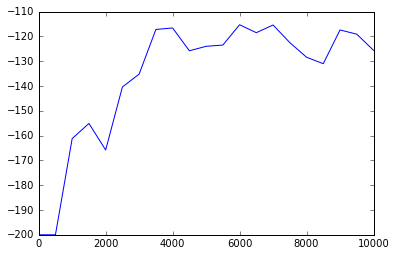

In [27]:
plt.ylabel('session reward')
plt.plot(iters,map(np.mean,session_rewards))
plt.xlabel('ticks')